## Simulation on the fully synthetic classification task

In [22]:
from mechanism_learn import pipeline as mlpipe
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Parameters

In [23]:
# Parameters for resampling
n_samples = [5000, 5000]
# Parameters for CWGMM
comp_k = 5
cov_type = 'full'
max_iter = 1000
tol = 1e-6
cov_reg = 1e-5
min_variance_value = 1e-5
init_method = 'kmeans++'
# Parameters for weights estimation
est_method = "histogram"
n_bins = [0, 10]
# Parameters for plotting
save_fig = False
save_dir = r"../../res_fig/"
figsize = (13,13)
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] =18
plt.rcParams["ytick.labelsize"] =18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] =18
plt.rcParams["axes.titlesize"] = 18
title_size = 21
axis_label_fontsize = 18
x_range = [-6, 6]
y_range = [-6, 6]
xaxis = [0, 0]
yaxis = [0, 0]
boundary_lw = 4
dot_marker_size = 10
dot_alpha = 0.4
color_map = {"true": "k", "confounder": "orange", "classifier": "r"}

### Visualization functions

In [24]:
def linear_decision_boundary(clf, xlim):
    weight = clf.coef_[0]
    bias = clf.intercept_[0]
    k = -weight[0] / weight[1]
    b = -bias / weight[1]
    x = np.linspace(xlim[0], xlim[1], 100)
    decison_boundary = k * x + b
    return decison_boundary

def plot_boundary(ax, X, Y, db, xlim, ylim, plot_title = None):
    handles = []
    scatter = ax.scatter(x= X[:,0], y = X[:,1], c = Y, s = dot_marker_size, alpha = dot_alpha, cmap='coolwarm')
    handles_scatter, _ = scatter.legend_elements(prop="colors")
    handles += handles_scatter
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    x_ = np.linspace(xlim[0], xlim[1], 100)
    
    true_b = ax.plot(xaxis, ylim, color = color_map["true"], 
                     linewidth=boundary_lw, label="True boundary")
    confounder = ax.plot(xlim, yaxis, color = color_map["confounder"], 
                         linewidth = boundary_lw, label = "Confounder boundary")
    clf_b = ax.plot(x_, db, color = color_map["classifier"], 
                    linewidth = boundary_lw, label= 'Classifier Decision')
    handles += [true_b[0], confounder[0], clf_b[0]]
    ax.set_title(plot_title)
    ax.set_xlabel(r"$X_1$", fontsize=axis_label_fontsize)
    ax.set_ylabel(r"$X_2$", fontsize=axis_label_fontsize)
    return ax, handles

### Load datasets

In [ ]:
syn_data_dir = r"../../test_data/synthetic_data/"
testcase_dir = r"syn_classification/"

X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv").to_numpy()
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv").to_numpy().ravel()
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv").to_numpy()

X_train_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_unconf.csv").to_numpy()
Y_train_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_unconf.csv").to_numpy().ravel()

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv").to_numpy()
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv").to_numpy().ravel()

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv").to_numpy()
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv").to_numpy().ravel()

# random sample 5000 from training set for faster training
idx_conf = np.random.choice(len(X_train_conf), 5000, replace=False)
X_train_conf = X_train_conf[idx_conf]
Y_train_conf = Y_train_conf[idx_conf]
Z_train_conf = Z_train_conf[idx_conf]

idx_unconf = np.random.choice(len(X_train_unconf), 5000, replace=False)
X_train_unconf = X_train_unconf[idx_unconf]
Y_train_unconf = Y_train_unconf[idx_unconf]


### Train a deconfounded SVM classifier using mechanism learning

In [17]:
ml_gmm_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                    mechanism_data = Z_train_conf, 
                                                    effect_data = X_train_conf, 
                                                    intv_values = np.unique(Y_train_conf), 
                                                    dist_map = None, 
                                                    est_method = est_method, 
                                                    n_bins = n_bins
                                                    )
cwgmm_model = ml_gmm_pipeline.cwgmm_fit(comp_k = comp_k,
                          max_iter = max_iter, 
                          tol = tol, 
                          init_method = init_method, 
                          cov_type = cov_type, 
                          cov_reg = cov_reg, 
                          min_variance_value=min_variance_value, 
                          random_seed=None, 
                          return_model = True,
                          verbose = 2)

deconf_X_gmm, deconf_Y_gmm = ml_gmm_pipeline.cwgmm_resample(n_samples=n_samples, return_samples = True)

deconf_gmm_clf = ml_gmm_pipeline.deconf_model_fit(ml_model = svm.SVC(kernel = 'linear', C=5))

CW-GMMs fitting:   0%|          | 0/2 [00:00<?, ?model/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

EM iter:   0%|          | 0/1000 [00:00<?, ?it/s]

### Train a deconfounded SVM classifier using CB-based deconfounding method

In [18]:
ml_cb_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                   mechanism_data = Z_train_conf, 
                                                   effect_data = X_train_conf, 
                                                   intv_values = np.unique(Y_train_conf), 
                                                   dist_map = None, 
                                                   est_method = est_method, 
                                                   n_bins = n_bins
                                                   )
deconf_X_cb, deconf_Y_cb = ml_cb_pipeline.cb_resample(n_samples = n_samples,
                                                      return_samples = True)

deconf_cb_clf = ml_cb_pipeline.deconf_model_fit(ml_model = svm.SVC(kernel = 'linear', C=5))

CB Resampling:   0%|          | 0/2 [00:00<?, ?it/s]

### Train a confounded SVM classifier

In [19]:
conf_clf = svm.SVC(kernel = 'linear', C=5)
conf_clf = conf_clf.fit(X_train_conf, Y_train_conf.reshape(-1))

nonconf_clf = svm.SVC(kernel = 'linear', C=5)
nonconf_clf = nonconf_clf.fit(X_train_unconf, Y_train_unconf.reshape(-1))

### Compare thier decision boundaries

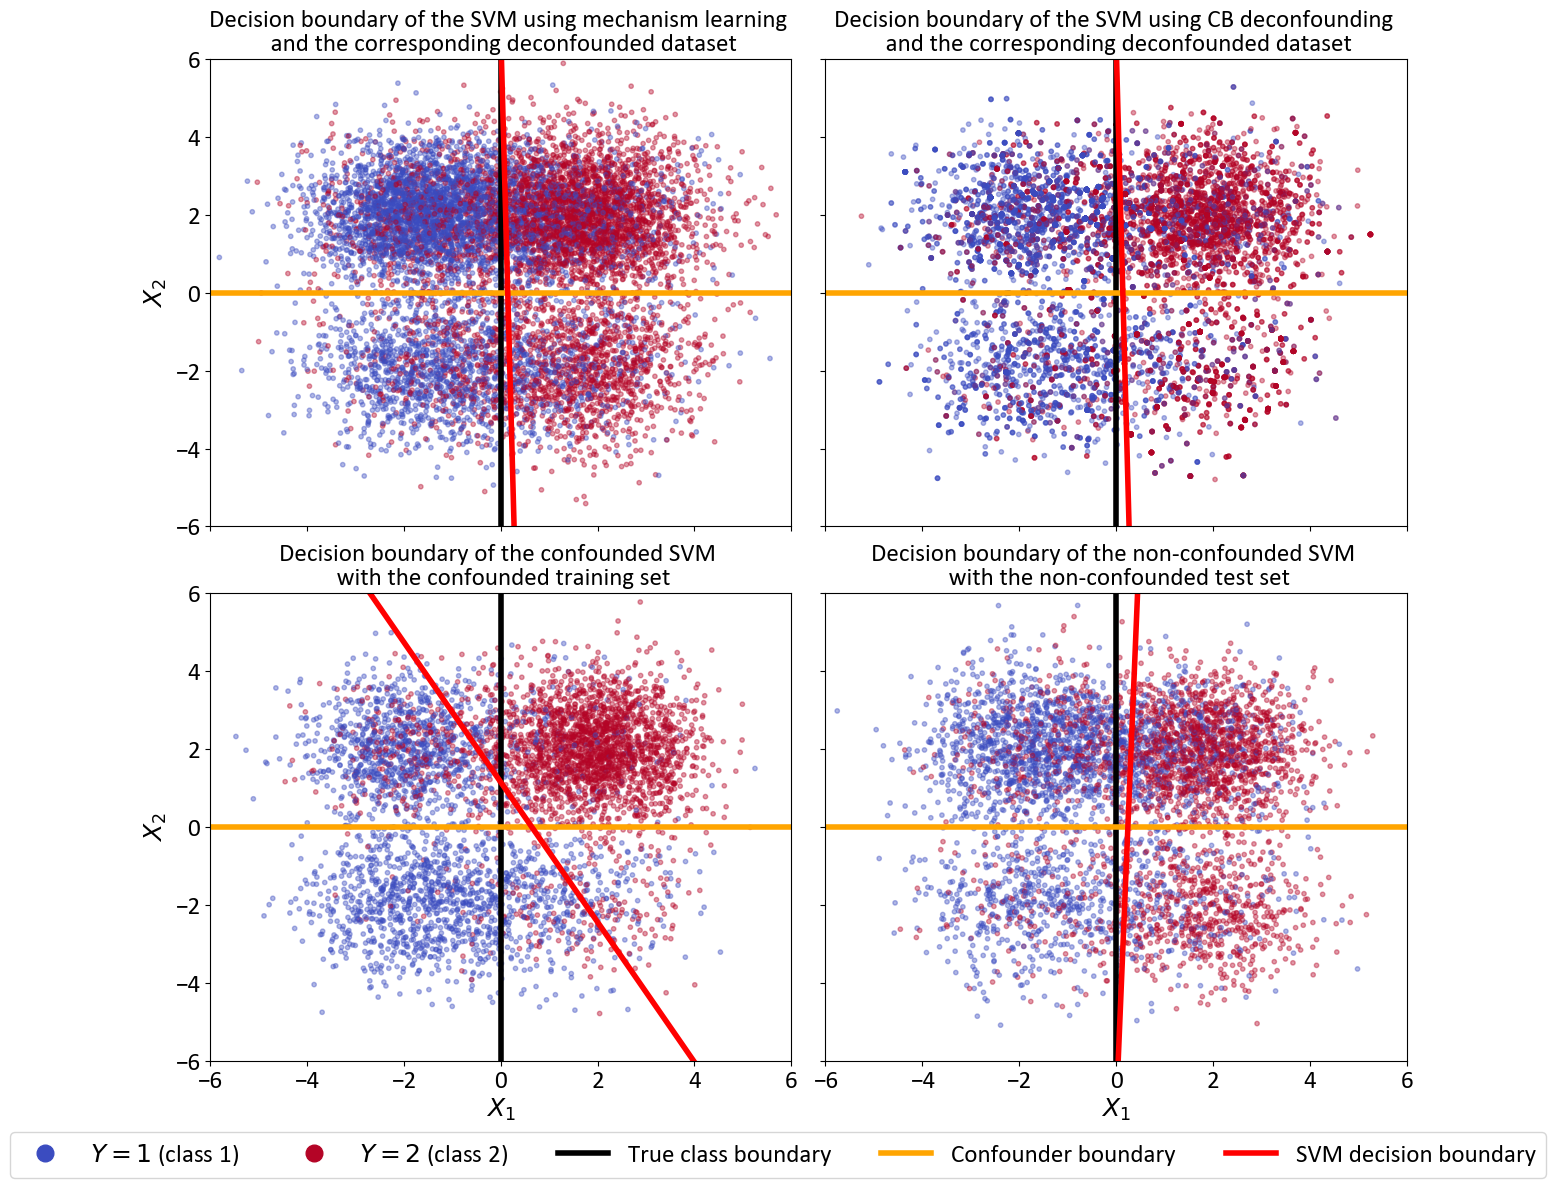

In [20]:
# randomize the dataset
rd_index = np.random.permutation(len(deconf_X_gmm))
deconf_X_gmm = deconf_X_gmm[rd_index]
deconf_Y_gmm = deconf_Y_gmm[rd_index]
rd_index = np.random.permutation(len(deconf_X_cb))
deconf_X_cb = deconf_X_cb[rd_index]
deconf_Y_cb = deconf_Y_cb[rd_index]

decision_boundary_deconf_gmm = linear_decision_boundary(clf = deconf_gmm_clf, xlim = x_range)
decision_boundary_deconf_cb = linear_decision_boundary(clf = deconf_cb_clf, xlim = x_range)
decision_boundary_conf = linear_decision_boundary(clf = conf_clf, xlim = x_range)
decision_boundary_nonconf = linear_decision_boundary(clf = nonconf_clf, xlim = x_range)

fig, axes = plt.subplots(2,2, figsize = figsize)
axes = axes.flatten()
axes[0], _ = plot_boundary(axes[0], deconf_X_gmm, deconf_Y_gmm, 
                        decision_boundary_deconf_gmm, x_range, y_range, 'Decision boundary of the SVM using mechanism learning \n and the corresponding deconfounded dataset')
axes[1], _ = plot_boundary(axes[1], deconf_X_cb, deconf_Y_cb, 
                        decision_boundary_deconf_cb, x_range, y_range, 'Decision boundary of the SVM using CB deconfounding \n and the corresponding deconfounded dataset')
axes[2], handles = plot_boundary(axes[2], X_train_conf, Y_train_conf, 
                        decision_boundary_conf, x_range, y_range, 'Decision boundary of the confounded SVM \n with the confounded training set')
axes[3], handles = plot_boundary(axes[3], X_train_unconf, Y_train_unconf, 
                        decision_boundary_nonconf, x_range, y_range, 'Decision boundary of the non-confounded SVM \n with the non-confounded test set')
axes[0].tick_params(labelbottom=False)
axes[0].set_xlabel('')  
axes[1].tick_params(labelbottom=False)
axes[1].set_xlabel('')  
axes[1].tick_params(labelleft=False)
axes[1].set_ylabel('')
axes[3].tick_params(labelleft=False)
axes[3].set_ylabel('')
# axes[0].set_title('(a)', loc='left', fontsize=title_size)
# axes[1].set_title('(b)', loc='left', fontsize=title_size)
# axes[2].set_title('(c)', loc='left', fontsize=title_size)
# axes[3].set_title('(d)', loc='left', fontsize=title_size)
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']
plt.tight_layout()
if save_fig:
    plt.savefig( "syn_clas_decision_boundaries.png", dpi=600)
legend =fig.legend(handles=handles,
                   labels=labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=len(labels),
                   markerscale=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.subplots_adjust(bottom=0.18)
plt.show()

### Compare thier performance on the confounded and non-confounded test datasets

In [21]:
decimal_digit = 4

print("Test on the non-confounded test set:")
y_pred_gmm_deconf_unconf = deconf_gmm_clf.predict(X_test_unconf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_unconf, y_pred_gmm_deconf_unconf, digits=decimal_digit))
print("-"*20)
y_pred_cb_deconf_unconf = deconf_cb_clf.predict(X_test_unconf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_unconf, y_pred_cb_deconf_unconf, digits=decimal_digit))
print("-"*20)
y_pred_conf_unconf = conf_clf.predict(X_test_unconf)
print("Report of confonded model:")
print(classification_report(Y_test_unconf, y_pred_conf_unconf, digits=decimal_digit))
print("-"*20)
y_pred_nonconf_unconf = nonconf_clf.predict(X_test_unconf)
print("Report of non-confounded model:")
print(classification_report(Y_test_unconf, y_pred_nonconf_unconf, digits=decimal_digit))
print("*"*30)

print("Test on the confounded test set:")
y_pred_gmm_deconf_conf = deconf_gmm_clf.predict(X_test_conf)
print("Report of deconfounded model using mechanism learning:")
print(classification_report(Y_test_conf, y_pred_gmm_deconf_conf, digits=decimal_digit))
print("-"*20)
y_pred_cb_deconf_conf = deconf_cb_clf.predict(X_test_conf)
print("Report of deconfounded model using CB-based method:")
print(classification_report(Y_test_conf, y_pred_cb_deconf_conf, digits=decimal_digit))
print("-"*20)
y_pred_conf_conf = conf_clf.predict(X_test_conf)
print("Report of confonded model:")
print(classification_report(Y_test_conf, y_pred_conf_conf, digits=decimal_digit))
print("-"*20)
y_pred_nonconf_conf = nonconf_clf.predict(X_test_conf)
print("Report of non-confounded model:")
print(classification_report(Y_test_conf, y_pred_nonconf_conf, digits=decimal_digit))

Test on the non-confounded test set:
Report of deconfounded model using mechanism learning:
              precision    recall  f1-score   support

          -1     0.7715    0.7279    0.7491      2510
           1     0.7405    0.7827    0.7610      2490

    accuracy                         0.7552      5000
   macro avg     0.7560    0.7553    0.7551      5000
weighted avg     0.7561    0.7552    0.7550      5000

--------------------
Report of deconfounded model using CB-based method:
              precision    recall  f1-score   support

          -1     0.7726    0.7267    0.7489      2510
           1     0.7401    0.7843    0.7616      2490

    accuracy                         0.7554      5000
   macro avg     0.7563    0.7555    0.7552      5000
weighted avg     0.7564    0.7554    0.7552      5000

--------------------
Report of confonded model:
              precision    recall  f1-score   support

          -1     0.7095    0.7024    0.7059      2510
           1     0.7030 